# 🎸 Guitar Strum Generator - Dataset Exploration

**Notebook 01: Explore Available Datasets**

This notebook explores the Chordonomicon dataset and other resources to understand what's available for training our guitar chord/strum generator.

---

**Key Finding:** No public dataset provides symbolic strumming patterns in "D_DU_UD_" format.  
**Our Strategy:** Combine synthetic generation (70%) with real progressions from Chordonomicon (30%).

---

## 1. Setup

In [11]:
# Install required packages
!pip install -q datasets pandas matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

print("✅ Setup complete!")

✅ Setup complete!


## 2. Load Chordonomicon

Chordonomicon contains **680,000 chord progressions** extracted from real songs.  
Source: https://huggingface.co/datasets/ailsntua/Chordonomicon

In [12]:
from datasets import load_dataset

print("📥 Loading Chordonomicon from Hugging Face...")
print("   (First time may take several minutes)\n")

dataset = load_dataset("ailsntua/Chordonomicon", split="train")
df = dataset.to_pandas()

print(f"✅ Loaded {len(df):,} entries!")
print(f"\n📋 Columns available:")
for col in df.columns:
    non_null = df[col].notna().sum()
    print(f"   - {col}: {non_null:,} non-null values")

📥 Loading Chordonomicon from Hugging Face...
   (First time may take several minutes)

✅ Loaded 679,807 entries!

📋 Columns available:
   - id: 679,807 non-null values
   - chords: 679,807 non-null values
   - release_date: 422,181 non-null values
   - genres: 429,753 non-null values
   - decade: 422,181 non-null values
   - rock_genre: 145,218 non-null values
   - artist_id: 510,986 non-null values
   - main_genre: 352,111 non-null values
   - spotify_song_id: 440,284 non-null values
   - spotify_artist_id: 510,986 non-null values


In [13]:
# Display first few rows
df.head(3)

,id,chords,release_date,genres,decade,rock_genre,artist_id,main_genre,spotify_song_id,spotify_artist_id
0,1,<intro_1> C <verse_1> F C E7 Amin C F C G7 C F...,None,'classic country pop',NaN,None,artist_1,pop,None,4AIEGdwDzPELXYgM5JaEY5
1,2,<intro_1> E D A/Cs E D A/Cs <verse_1> E D A/Cs...,2003-01-01,'alternative metal' 'alternative rock' 'nu met...,2000.0,pop rock,artist_2,metal,2ffJZ2r8HxI5DHcmf3BO6c,694QW15WkebjcrWgQHzRYF
2,3,<intro_1> Csmin <verse_1> A Csmin A Csmin A Cs...,2003-01-01,'alternative metal' 'canadian rock' 'funk meta...,2000.0,canadian rock,artist_3,metal,5KiY8SZEnvCPyIEkFGRR3y,0niJkG4tKkne3zwr7I8n9n


## 3. Understand the Chord Format

Chordonomicon uses **structural tags** in the chord strings:
- `<intro_1>`, `<verse_1>`, `<chorus_1>`, etc.
- These indicate song sections

In [14]:
# Look at a few chord progression examples
print("🎵 Sample chord progressions:\n")

for i in range(5):
    row = df.iloc[i]
    chords = str(row['chords'])
    # Truncate for display
    if len(chords) > 150:
        chords = chords[:150] + "..."
    
    print(f"Example {i+1}:")
    print(f"  {chords}")
    print()

🎵 Sample chord progressions:

Example 1:
  <intro_1> C <verse_1> F C E7 Amin C F C G7 C F C E7 Amin C F G7 C <verse_2> F C E7 Amin C F C G7 C F C E7 Amin C F G7 C <chorus_1> F C F C G C F C E7 ...

Example 2:
  <intro_1> E D A/Cs E D A/Cs <verse_1> E D A/Cs E D A/Cs E D A/Cs E D A C <chorus_1> E G D A E G D A E G D A C D E D A/Cs <verse_2> E D A/Cs E D A/Cs E...

Example 3:
  <intro_1> Csmin <verse_1> A Csmin A Csmin A Csmin A B <chorus_1> Csmin A Fsmin A B <verse_2> Csmin A Csmin A Csmin A Csmin A Fsmin <chorus_2> Csmin A ...

Example 4:
  <intro_1> D Dmaj7 D Dmaj7 <verse_1> Emin A D G Emin A D G Emin A D G Emin A D <chorus_1> Emin A D G Emin A D G D/Fs Emin A D G D/Fs Emin A D G <verse_...

Example 5:
  <intro_1> C <verse_1> G C G C <chorus_1> F Dmin G Dmin G C <verse_2> G C <chorus_2> F Dmin G Dmin G C F Dmin G Dmin7 G C <verse_3> G C <chorus_3> F Dm...



In [15]:
# Extract and count section tags
def extract_sections(chord_string):
    """Extract section tags from chord string."""
    pattern = r'<(\w+)_?\d*>'
    return re.findall(pattern, str(chord_string))

# Count all sections across dataset
all_sections = []
for chords in df['chords'].dropna().sample(10000):  # Sample for speed
    all_sections.extend(extract_sections(chords))

section_counts = Counter(all_sections)

print("📊 Most common section tags:")
for section, count in section_counts.most_common(10):
    print(f"   <{section}>: {count:,}")

📊 Most common section tags:
   <verse_1>: 5,425
   <verse_2>: 4,958
   <chorus_1>: 4,929
   <chorus_2>: 4,506
   <intro_1>: 3,881
   <chorus_3>: 2,781
   <outro_1>: 2,374
   <bridge_1>: 2,275
   <verse_3>: 2,081
   <instrumental_1>: 809


## 4. Extract Unique Chords

Let's see what chord symbols appear in the dataset.

In [16]:
def extract_chords(chord_string):
    """Extract chord symbols from chord string."""
    # Remove section tags
    clean = re.sub(r'<\w+_?\d*>', ' ', str(chord_string))
    # Split and filter
    tokens = clean.split()
    # Basic chord pattern
    chord_pattern = r'^[A-Ga-g][#b]?(m|maj|min|dim|aug|sus|add|7|9|11|13|M)*\d*$'
    chords = [t for t in tokens if re.match(chord_pattern, t, re.IGNORECASE)]
    return chords

# Extract chords from sample
all_chords = []
for chord_str in df['chords'].dropna().sample(50000):
    all_chords.extend(extract_chords(chord_str))

chord_counts = Counter(all_chords)

print(f"📊 Found {len(chord_counts):,} unique chord symbols")
print(f"\nMost common chords:")
for chord, count in chord_counts.most_common(20):
    pct = count / len(all_chords) * 100
    bar = '█' * int(pct)
    print(f"   {chord:8} {count:>6,} ({pct:4.1f}%) {bar}")

📊 Found 355 unique chord symbols

Most common chords:
   G        506,376 (15.1%) ███████████████
   C        421,633 (12.5%) ████████████
   D        375,365 (11.2%) ███████████
   A        281,889 ( 8.4%) ████████
   F        247,674 ( 7.4%) ███████
   Amin     214,635 ( 6.4%) ██████
   E        195,628 ( 5.8%) █████
   Emin     191,889 ( 5.7%) █████
   Bmin     103,407 ( 3.1%) ███
   B        99,440 ( 3.0%) ██
   Dmin     91,207 ( 2.7%) ██
   Bb       72,570 ( 2.2%) ██
   Gmin     41,334 ( 1.2%) █
   Eb       35,335 ( 1.1%) █
   Cmin     29,547 ( 0.9%) 
   Ab       25,980 ( 0.8%) 
   A7       21,925 ( 0.7%) 
   Fmin     20,911 ( 0.6%) 
   Amin7    20,817 ( 0.6%) 
   Emin7    20,726 ( 0.6%) 


## 5. Genre Distribution

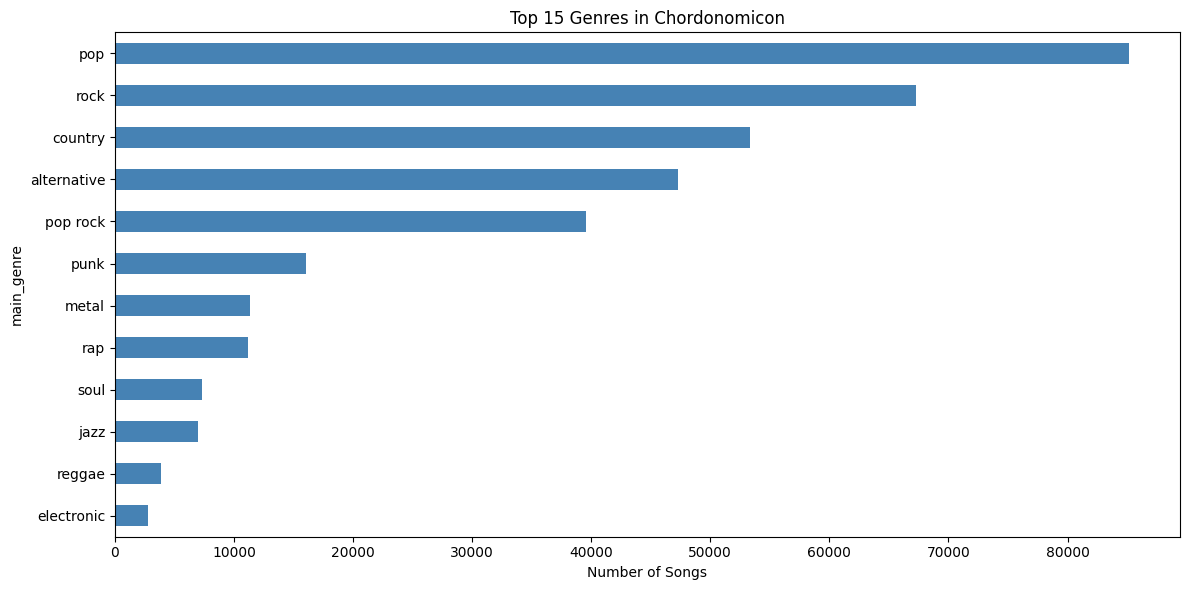


📊 Genre statistics:
   pop                    85,185 ( 12.5%)
   rock                   67,238 (  9.9%)
   country                53,306 (  7.8%)
   alternative            47,252 (  7.0%)
   pop rock               39,557 (  5.8%)
   punk                   16,066 (  2.4%)
   metal                  11,315 (  1.7%)
   rap                    11,186 (  1.6%)
   soul                    7,350 (  1.1%)
   jazz                    7,001 (  1.0%)


In [17]:
# Main genre distribution
if 'main_genre' in df.columns:
    genre_counts = df['main_genre'].value_counts()
    
    plt.figure(figsize=(12, 6))
    genre_counts.head(15).plot(kind='barh', color='steelblue')
    plt.xlabel('Number of Songs')
    plt.title('Top 15 Genres in Chordonomicon')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Genre statistics:")
    for genre in genre_counts.head(10).index:
        count = genre_counts[genre]
        pct = count / len(df) * 100
        print(f"   {genre:20} {count:>8,} ({pct:5.1f}%)")

## 6. Decade Distribution

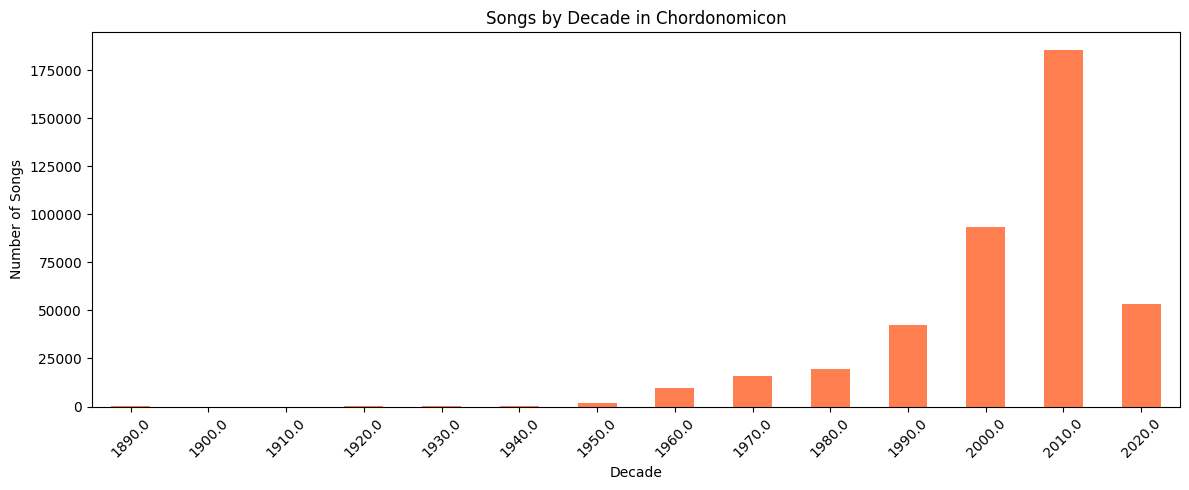

In [18]:
if 'decade' in df.columns:
    decade_counts = df['decade'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 5))
    decade_counts.plot(kind='bar', color='coral')
    plt.xlabel('Decade')
    plt.ylabel('Number of Songs')
    plt.title('Songs by Decade in Chordonomicon')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 7. Chord Progression Length Analysis

📊 Chord progression length statistics (sample of 10,000):
   Min: 0
   Max: 2101
   Mean: 67.3
   Median: 62


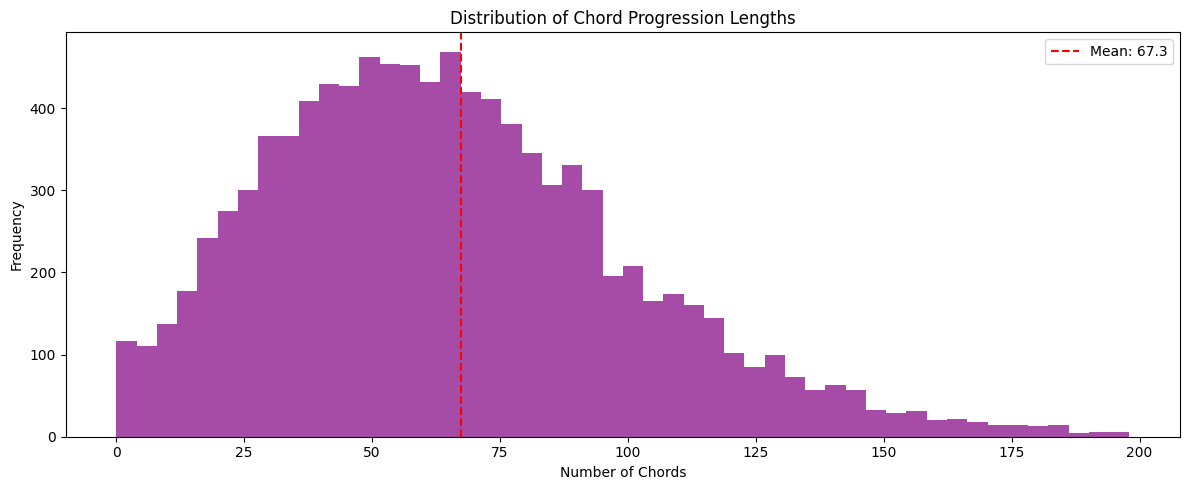

In [19]:
# Calculate progression lengths
def count_chords(chord_string):
    return len(extract_chords(chord_string))

# Sample for speed
sample_df = df.sample(10000)
lengths = sample_df['chords'].apply(count_chords)

print(f"📊 Chord progression length statistics (sample of 10,000):")
print(f"   Min: {lengths.min()}")
print(f"   Max: {lengths.max()}")
print(f"   Mean: {lengths.mean():.1f}")
print(f"   Median: {lengths.median():.0f}")

plt.figure(figsize=(12, 5))
plt.hist(lengths[lengths < 200], bins=50, color='purple', alpha=0.7)
plt.xlabel('Number of Chords')
plt.ylabel('Frequency')
plt.title('Distribution of Chord Progression Lengths')
plt.axvline(lengths.mean(), color='red', linestyle='--', label=f'Mean: {lengths.mean():.1f}')
plt.legend()
plt.tight_layout()
plt.show()

## 8. Key Finding: What's Missing?

### ❌ What Chordonomicon DOES NOT have:
- **Strumming patterns** (D_DU_UD_ format)
- **Natural language descriptions/prompts**
- **Tempo information**
- **Emotion labels**

### ✅ What Chordonomicon DOES have:
- **Real chord progressions** from 680,000 songs
- **Genre labels** (rock, pop, folk, etc.)
- **Structural tags** (verse, chorus, etc.)
- **Decade information**

### 💡 Our Strategy:
1. **Extract real chord progressions** from Chordonomicon
2. **Add strumming patterns** using our rule-based system
3. **Generate natural language prompts** using templates
4. **Combine with synthetic samples** for complete coverage

In [20]:
# Summary
print("="*60)
print("📊 CHORDONOMICON SUMMARY")
print("="*60)
print(f"\n✅ Total entries: {len(df):,}")
print(f"✅ Has genre labels: {'main_genre' in df.columns}")
print(f"✅ Has structural tags: Yes (verse, chorus, etc.)")
print(f"✅ Real chord progressions: Yes")
print(f"\n❌ Strumming patterns: NO - must add synthetically")
print(f"❌ Natural language prompts: NO - must generate")
print(f"❌ Tempo information: NO - must infer/assign")
print(f"\n💡 Use case for thesis:")
print(f"   Sample ~75 real progressions as 30% of training data")
print(f"   Add strumming + prompts using our rule-based system")
print("="*60)

📊 CHORDONOMICON SUMMARY

✅ Total entries: 679,807
✅ Has genre labels: True
✅ Has structural tags: Yes (verse, chorus, etc.)
✅ Real chord progressions: Yes

❌ Strumming patterns: NO - must add synthetically
❌ Natural language prompts: NO - must generate
❌ Tempo information: NO - must infer/assign

💡 Use case for thesis:
   Sample ~75 real progressions as 30% of training data
   Add strumming + prompts using our rule-based system


## 9. Next Steps

Continue to **Notebook 02: Build Dataset** to create the training data!